In [135]:
import numpy as np
import matplotlib.pyplot as ply
import pandas as pd
import math
%matplotlib inline

In [136]:
# Item object -> takes in data, operator, label, child nodes as values
# Operations it can perform -> Add, Subtract, Multiply, Divide, Power
# Activation functions -> Tanh, Sigmoid, Relu
# Can take grad as well as input -> not required in initialization(calculated during back prop)

In [137]:
class Item:

    def __init__(self,data,child_nodes=(),operator='',label=''):

        self.data = data
        self.child_nodes = set(child_nodes)
        self.operator = operator
        self.label = label
        self.grad = 0.0
        self.backprop = lambda : None

    def __repr__(self):
        return f"Item(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other,Item) else Item(other)
        out = Item((self.data + other.data),(self,other),'+')

        def backprop():

          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad

        out.backprop = backprop
        return out

    def __radd__(self,other):
        return self + other

    def __mul__(self,other):
        other = other if isinstance(other,Item) else Item(other)
        out =  Item((self.data * other.data),(self,other),'*')

        def backprop():
          self.grad += other.data
          other.grad += self.data

        out.backprop = backprop
        return out

    def __rmul__(self,other):
        return self * other

    def __neg__(self):
        return -1 * self

    def __sub__(self,other):
        other = other if isinstance(other,Item) else Item(other)
        return self + (-other)

    def __rsub__(self,other):
        return (-self) + other

    def __pow__(self,power):
        assert isinstance(power,(int,float))  # Power only supports ints and floats, so assert checks that(if fails, raises as assertion error)
        out = Item(self.data ** power,(self,),f'pow of {power}')

        def backprop():
          self.grad = power * (self ** (power - 1))*out.grad

        out.backprop = backprop
        return out

    def __truediv__(self,other):
        return self * (other**-1)

    def exp(self):
      out =  Item(math.exp(self.data),(self,),'exp')

      def backprop():
        self.grad += math.exp(self.data) * out.data

      out.backprop = backprop
      return out

    def tanh(self):

      x = self.data
      t = ((math.exp(2*x) - 1) / (math.exp(2*x) + 1))
      out = Item(t,(self,),'tanh') # (self,) -> its a tuple of 1 object

      def backprop():

        self.grad += (1 - (t**2)) * out.grad

      out.backprop = backprop
      return out

    def sigmoid(self):

      t = (math.exp(self.data)) / (1 + math.exp(self.data))
      out = Item(t,(self,),'sigmoid')

      def backprop():
        self.grad += t*(1-t)*out.grad

      out.backprop = backprop
      return out

    def relu(self):

      t = max(0,self.data)
      out = Item(t,(self,),'relu')

      def backprop():

        if t == 0:
          self.grad = 0
        else:
          self.grad += 1.0 * out.grad
      out.backprop = backprop
      return out

    def backward(self):

      # Topological sort of traversing through a graph, so that each node is visited(done so that for each node we can do _backward later instead of doing it manually)
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v.child_nodes:
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node.backprop()

In [138]:
a = Item(1)
b = Item(-5)
c = a * b
d = 10
e = c + d
e

Item(data=5)

In [139]:
a.relu()

Item(data=1)

In [140]:
# Used for visualizing a graph
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.child_nodes:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.operator:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operator, label = n.operator)
      # and connect this node to it
      dot.edge(uid + n.operator, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

  return dot

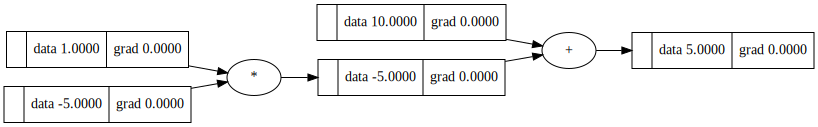

In [141]:
draw_dot(e)

In [142]:
e.backward()

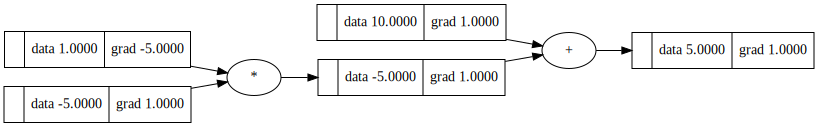

In [143]:
draw_dot(e)

In [144]:
# Manual Backprop for NN (2 inputs, 1 neuron hidden layer, 1 output)

# Inputs
x1 = Item(10.0,label='x1')
x2 = Item(15.0,label='x2')

# Weights and bias
w1 = Item(0.2,label='w1')
w2 = Item(0.17,label='w2')
b = Item(1.5,label='b')

# Hidden layer
h = w1*x1 + w2*x2 + b

o1 = h.relu()
o2 = h.tanh()
o3 = h.sigmoid()

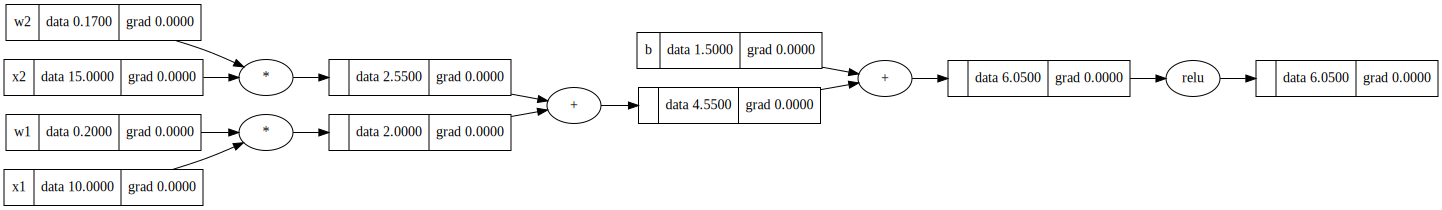

In [145]:
draw_dot(o1)

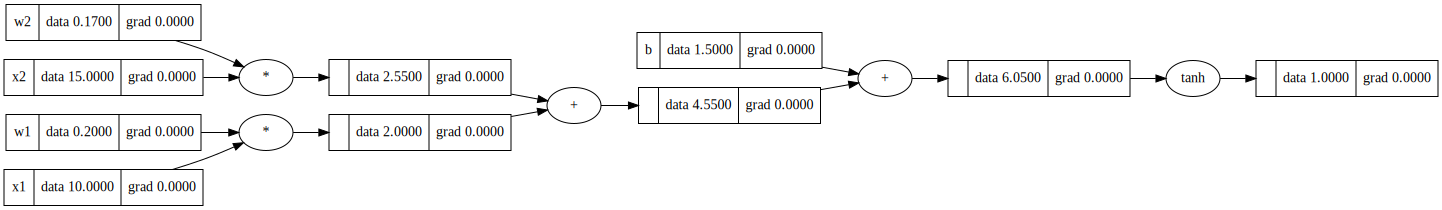

In [146]:
draw_dot(o2)

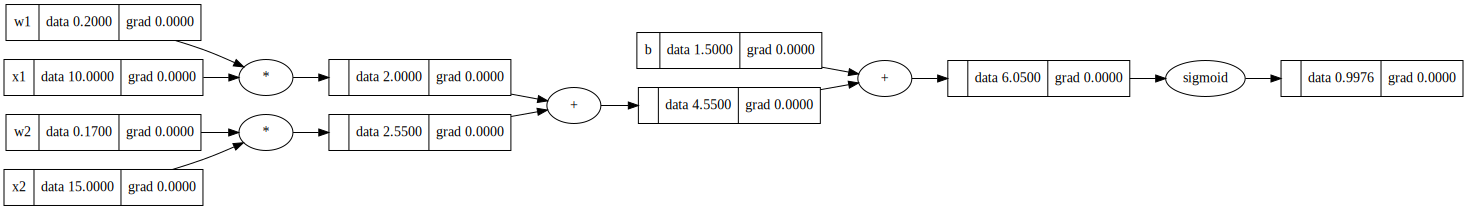

In [147]:
draw_dot(o3)

In [148]:
# Backprop

In [149]:
o1.backward()

In [150]:
o2.backward()

In [151]:
o3.backward()

In [152]:
# Using pytorch for the same(single MLP neuron)

In [153]:
import torch

In [154]:
x1 = torch.tensor([2.0]).double();x1.requires_grad=True
x2 = torch.tensor([5.0]).double();x2.requires_grad=True

w1 = torch.tensor([2.0]).double();w1.requires_grad=True
w2 = torch.tensor([2.0]).double();w2.requires_grad=True

b = torch.tensor([1.7]).double()

w1x1 = w1 * x1
w2x2 = w2 * x2
w1x1w2x2 = w1*x1 + w2*x2
o = torch.tanh(w1x1w2x2 + b)
o.backward()

In [155]:
print(o)
print('---')
print(o.data)
print('---')
print(o.data.item())

print('---')
print('x2', x2.grad)
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([1.0000], dtype=torch.float64, grad_fn=<TanhBackward0>)
---
tensor([1.0000], dtype=torch.float64)
---
0.9999999999999538
---
x2 tensor([1.8474e-13], dtype=torch.float64)
---
x2 1.8474111129762178e-13
w2 4.618527782440544e-13
x1 1.8474111129762178e-13
w1 1.8474111129762178e-13


In [156]:
# MLP Implementation

In [157]:
# Neuron

import random
class Neuron:

  def __init__(self,nin): # nin -> number of inputs

    self.w = [Item(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Item(random.uniform(-1,1))

  def __call__(self,x): # x -> input

    out = sum([wi * xi for wi,xi in zip(self.w,x)], self.b)
    out_act = out.tanh()
    return out_act

  def parameters(self):

    return self.w + [self.b]

In [158]:
n = Neuron(3)
x = [2.0,3.0,4.0]
n(x)

Item(data=-0.7085163027352095)

In [159]:
n.parameters()

[Item(data=-0.9435797742463152),
 Item(data=0.49311530550428073),
 Item(data=0.03361147234402706),
 Item(data=-0.610830525629962)]

In [160]:
# Layer

class Layer:

  def __init__(self,nin,nout): # nin -> number of inputs, nout -> number of neurons(number of outputs)
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [parameters for neuron in self.neurons for parameters in neuron.parameters()] # Each parameter of each neuron in self.neurons

In [161]:
l = Layer(3,4)
x = [3.0,4.0,5.0]
l(x)

[Item(data=-0.9999998432446651),
 Item(data=0.9999313906094225),
 Item(data=-0.9997843191249614),
 Item(data=0.999999738804562)]

In [162]:
l.parameters()

[Item(data=-0.4243371793483939),
 Item(data=-0.8291861230369111),
 Item(data=-0.6194984050029364),
 Item(data=-0.4936153077796621),
 Item(data=-0.39481659038688544),
 Item(data=0.9252937148898439),
 Item(data=0.7166780693319286),
 Item(data=-0.9600184255619426),
 Item(data=-0.3637894595358053),
 Item(data=0.5159457629552018),
 Item(data=-0.963945442132347),
 Item(data=-0.7200624662716237),
 Item(data=0.998362660745054),
 Item(data=0.8372127542089083),
 Item(data=0.21468333410726737),
 Item(data=0.5082163080631947)]

In [163]:
# MLP

class MLP:

  def __init__(self,nin,nout): # nin -> Number of inputs, nout -> Number of neurons in each layer in list format
    total_inputs = [nin] + nout
    self.layers = [Layer(total_inputs[i],total_inputs[i+1]) for i in range(len(nout))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [parameter for layer in self.layers for parameter in layer.parameters()]

In [164]:
m = MLP(3,[4,5,1])
x = [2.0,3.0,4.0]
m(x)

Item(data=-0.424076112233624)

In [165]:
m.parameters()

[Item(data=0.011711311970273863),
 Item(data=-0.7297667549746063),
 Item(data=-0.8001286596101087),
 Item(data=-0.45855501698813894),
 Item(data=-0.2984541672862133),
 Item(data=-0.45919194106479266),
 Item(data=-0.7454029431807545),
 Item(data=-0.8087729291596442),
 Item(data=-0.5912240274877136),
 Item(data=-0.85894521454901),
 Item(data=-0.6739063809243888),
 Item(data=-0.045812038456517934),
 Item(data=-0.4942008606824224),
 Item(data=-0.3328065356084611),
 Item(data=-0.3444780933814693),
 Item(data=0.2598554176182546),
 Item(data=0.3336143345746949),
 Item(data=-0.3405962155923219),
 Item(data=-0.966264735028336),
 Item(data=0.18135020227458942),
 Item(data=-0.10003289323623221),
 Item(data=0.40693181348168106),
 Item(data=0.7484129903726975),
 Item(data=-0.06045844364308506),
 Item(data=-0.21921143865234627),
 Item(data=0.7291903603623602),
 Item(data=-0.28915337024848387),
 Item(data=0.8389602431478917),
 Item(data=0.06759855019315708),
 Item(data=-0.8633736252332904),
 Item(dat

In [166]:
# Predictions and Backprop

In [167]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0]
]
ys = [1.0, -1.0, 1.0] # desired targets

In [168]:
ypred = [m(x) for x in xs]
ypred

[Item(data=-0.49400755730810875),
 Item(data=-0.8059774404964537),
 Item(data=-0.5879802268743199)]

In [169]:
# Loss -> MSE
loss_list = [(yout - ysi)** 2 for yout,ysi in zip(ypred,ys)]

loss = Item(0)
for l in loss_list:
  loss += l
loss

Item(data=4.791384535833867)

In [170]:
loss.backward()

In [171]:
# Forward and Backward passes with weight updation

In [172]:
# MLP initialization
m = MLP(3,[4,5,1])
x = [2.0,3.0,4.0]
m(x)

Item(data=0.5249133375344547)

In [173]:
m.parameters()

[Item(data=0.8220447502766599),
 Item(data=0.009088307336529322),
 Item(data=0.8966113695994711),
 Item(data=0.9965473886238241),
 Item(data=-0.9301662691668937),
 Item(data=-0.6286979930939496),
 Item(data=-0.7578108952208618),
 Item(data=0.09855219142150684),
 Item(data=-0.11881661505783514),
 Item(data=-0.8838663453258537),
 Item(data=-0.5113847004509011),
 Item(data=0.6290366836761372),
 Item(data=0.076657137018038),
 Item(data=-0.2246826993168094),
 Item(data=-0.31057902324187503),
 Item(data=0.44680053144116383),
 Item(data=0.6346289720638418),
 Item(data=-0.9856146228100782),
 Item(data=-0.14951428873585382),
 Item(data=0.3843259673993089),
 Item(data=0.9625833976260676),
 Item(data=-0.6502378865191663),
 Item(data=0.18505620037676906),
 Item(data=-0.6942354793008718),
 Item(data=-0.6044320575870652),
 Item(data=0.14042285217854156),
 Item(data=0.7274202835985759),
 Item(data=-0.8277735476255452),
 Item(data=0.6798492753448622),
 Item(data=0.8282823779513626),
 Item(data=0.41242

In [174]:
# Forward pass
ypred = [m(x) for x in xs]
loss_list = [(yout - ysi)** 2 for yout,ysi in zip(ypred,ys)]

loss = Item(0)
for l in loss_list:
  loss += l
print(loss)

#Backward pass
for parameter in m.parameters():
  parameter.grad = 0.0
  loss.backward()
for parameter in m.parameters():
  parameter.data += -0.1 * parameter.grad #(- learningrate * d(L)/d(W))

Item(data=1.9427401774675488)
